# ファイルの読み込み

In [1]:
# 必要ライブラリのインポート
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認
import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
!pip install japanize-matplotlib
import japanize_matplotlib

# 2022/06/02追加: Kaggle notebook環境変更のため
!pip install pandas_profiling==3.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=7192572ac1054fe7ce9cc196c656e7996e12679ea171c8db551f9d3aead9c65d
  Stored in directory: /root/.cache/pip/wheels/d3/7d/c5/d3e02382561888f86edabf3256c09b3298f8e24456f8fc4da3
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
  Attempting uninstall: visions
    Found existing installation: visions 0.7.5
    Uninstalling visions-0.7.5:
      Successfully uninstalled visions-0.7.5
 

# データの確認（簡易）

In [2]:
#ファイル読み込み
df_train = pd.read_csv("../input/titanic/train.csv")
df_train.head()

#Excelファイル　df = pd.read_excel("ファイル名")
#タブ区切り　　　df = pd_read_CSV("sample.tst", sep="\t")
#Shift JIS形式のCSVファイル　df = pd.read_CSV("sample.csv", encoding="Shift_jis")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#データの確認(レコード数とカラム数)
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


In [4]:
#データの確認(info)型やnullの確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#データ型の変換
#間隔尺度をカテゴリ変数に変換

#int型からオブジェクト型へ変換
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train[["Pclass"]].info()

#オブジェクト型からint型へ変換
df_train["Pclass"] = df_train["Pclass"].astype(np.int64)
df_train[["Pclass"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [6]:
#欠損値の確認
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# データセット作成

In [7]:
#説明変数に"Pclass"と"fare"　欠損値がなく、intだから
#目的変数に"Survived"
#生存者ID
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


# バリデーション設計

In [8]:
#ホールドアウト検証の実行 8:2で分割　
#学習データと検証データに含まれる"1"の割合が同じになるようにする stratify = y_train
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


In [9]:
#交差検証を実行　K=5
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))
for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),
        y_tr["Survived"].mean(),
        y_va["Survived"].mean(),
    ))

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


# モデル学習（勾配ブースティング）

In [10]:

#モデル学習（勾配ブースティング・ホールドアウト検証）

#1 データセットの作成
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]


print(x_train.shape, y_train.shape, id_train.shape)
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

#2 モデルの学習
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr,
          y_tr,
          eval_set=[(x_tr,y_tr), (x_va,y_va)],
          early_stopping_rounds=100,
          verbose=10,
         )

#モデルの評価
y_tr_pred = model.predict_proba(x_tr)[:,1]
y_va_pred = model.predict_proba(x_va)[:,1]

metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5, 1, 0))
metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5, 1, 0))

print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))

#説明変数の重要度の算出
imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp", ascending=False, ignore_index=True)

(891, 2) (891, 1) (891, 1)
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc: 0.834593	valid_1's auc: 0.750132
[100]	training's auc: 0.837247	valid_1's auc: 0.747892
[110]	training's auc: 0.839036	valid_1's auc: 0.746838
[120]	training's auc: 0.840764	valid_1's auc: 0.746311
[130]	training's auc: 0.842007	valid_1's auc: 0.746706
[accuracy] tr: 0.75, va: 0.73


,col,imp
0,Fare,903.440373
1,Pclass,229.457186


In [11]:

#モデル学習（勾配ブースティング・交差検証）

#1 データセットの作成
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], \
                             df_train[["Survived"]], \
                             df_train[["PassengerId"]]


print(x_train.shape, y_train.shape, id_train.shape)
x_tr, x_va, y_tr, y_va = train_test_split(x_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train, 
                                          random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
    y_train["Survived"].mean(),
    y_tr["Survived"].mean(),
    y_va["Survived"].mean(),
))

#2 モデルの学習
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
    
metrics = []
imp = pd.DataFrame()

n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
        y_train["Survived"].mean(),
        y_tr["Survived"].mean(),
        y_va["Survived"].mean(),
    ))
    
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr), (x_va,y_va)],
              early_stopping_rounds=100,
              verbose=100,
             )
#モデルの評価
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    
    metrics.append([nfold, metric_tr, metric_va])
    
    _imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_, "nfold":nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print("-"*20, "result", "-"*20)
metrics = np.array(metrics)
print(metrics)

print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std(),
))

imp = imp.groupby("col")["imp"].agg(["mean", "std"])
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)

print("Done.")

#説明変数の重要度の算出
imp = pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp", ascending=False, ignore_index=True)

(891, 2) (891, 1) (891, 1)
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.826717	valid_1's auc: 0.753008
[accuracy] tr: 0.75, va: 0.68
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.839483	valid_1's auc: 0.732687
[200]	training's auc: 0.849542	valid_1's auc: 0.737233
[accuracy] tr: 0.77, va: 0.69
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[100]	training's auc: 0.831826	valid_1's auc: 0.752941
[accuracy] tr: 0.75, va: 0.69
-------------------- 4 ---------

,col,imp
0,Fare,175.473267
1,Pclass,169.153896


# ベースラインを使用する場合の手順

In [12]:
#ベースライン検証用データの作成
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=y_train,
                                            random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


In [13]:
#学習データと検証データの分割（ホールドアウト法）
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


In [14]:
#モデル学習（ホールドアウト法）
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1), (x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[20]	training's auc: 0.810025	valid_1's auc: 0.712087
[30]	training's auc: 0.822545	valid_1's auc: 0.72376
[40]	training's auc: 0.829204	valid_1's auc: 0.719421
[50]	training's auc: 0.836699	valid_1's auc: 0.720455
[60]	training's auc: 0.841808	valid_1's auc: 0.716322
[70]	training's auc: 0.84684	valid_1's auc: 0.71281
[80]	training's auc: 0.851009	valid_1's auc: 0.716529
[90]	training's auc: 0.85472	valid_1's auc: 0.720041
[100]	training's auc: 0.856354	valid_1's auc: 0.722934


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [15]:
#検証データとベースライン検証用データの予測値算出
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

In [16]:
#モデル精度の比較
print("[検証データ] acc: {:.4f}".format(accuracy_score(y_va1, y_va1_pred)))
print("[ベースライン検証用データ] acc: {:.4f}".format(accuracy_score(y_va2, y_va2_pred)))

[検証データ] acc: 0.7133
[ベースライン検証用データ] acc: 0.7095


In [17]:
#誤差分布の比較
print("検証データ")
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize="all"))
print("ベースライン検証用データ")
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize="all"))

検証データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


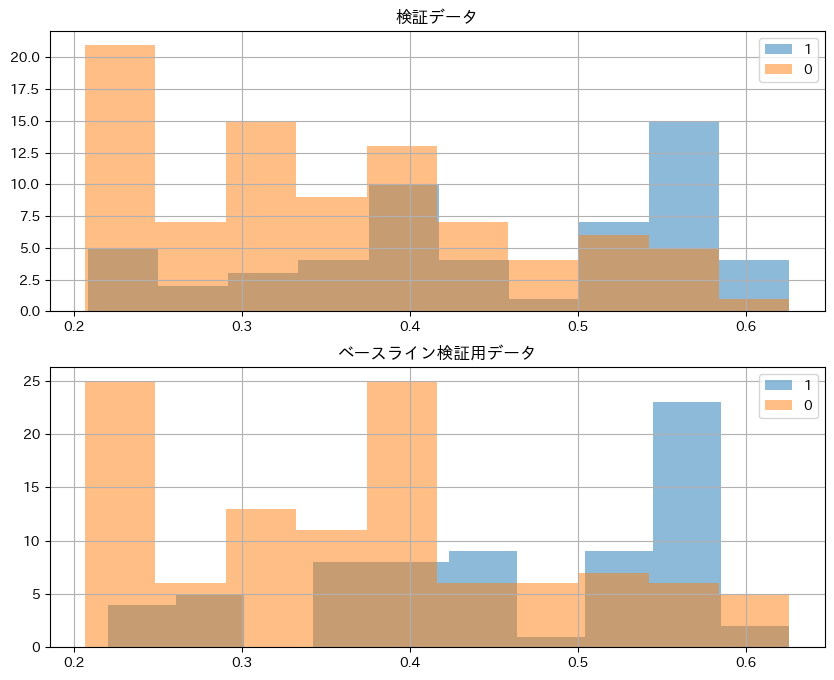

In [18]:
#予測値の分布比較

#予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2,1,1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証用データ
fig.add_subplot(2,1,2)
plt.title("ベースライン検証用データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

# モデル推論

In [19]:
#モデル推論 未知データを用いた推論

#推論データセット作成
df_test = pd.read_csv("../input/titanic/test.csv")
x_test = df_test[["Pclass", "Fare"]]
id_test = df_test[["PassengerId"]]

#学習による推論
y_test_pred = model.predict(x_test)

#提出ファイルの作成
df_submit = pd.DataFrame({"PassengerId":id_test["PassengerId"], "Survived":y_test_pred})
display(df_submit.head(5))
df_submit.to_csv("submission_baseline.csv", index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
